# DC-GAN - Type 4 - Diabetic Retinopathy

In [1]:
import os
import sys
import glob
import json
import random
import argparse
import subprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
os.environ[ "CUDA_VISIBLE_DEVICES" ]="0"

In [4]:
seed = 369
random.seed(seed)
torch.manual_seed(seed)

### HyperParameters

In [5]:
params = {
    "bsize" : 8, # Batch size during training.
    'imsize' : 360, # Spatial size of training images.
    'nc' : 3, # Number of channles in the training images.
    'nz' : 100, # Size of the Z latent vector.
    'ngf' : 32, # Size of feature maps in the generator.
    'ndf' : 64, # Size of features maps in the discriminator.
    'nepochs' : 250, # Number of training epochs.
    'lr' : 0.0002, # Learning rate for optimizers
    'beta1' : 0.5, # Beta1 hyperparam for Adam optimizer
    'save_epoch' : 5 # Save step.
}

### Data Loader

In [6]:
root = './dataset/dcgan_v3/train4'

def load_dataset(params):
    # Data proprecessing.
    
    transform = transforms.Compose([
        transforms.Resize(params['imsize']),
        transforms.CenterCrop(params['imsize']),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5))])

    dataset = dset.ImageFolder(root=root, transform=transform)

    dataloader = torch.utils.data.DataLoader(dataset,
        batch_size=params['bsize'],
        shuffle=True, num_workers= 16)

    return dataloader

In [7]:
device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")

### Training Samples

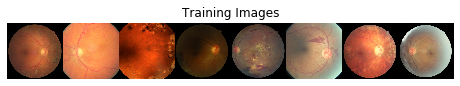

In [8]:
dataloader = load_dataset(params)

sample_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
   sample_batch[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

## Discriminator, Generator & Parameter Definitions

In [9]:
def weights_init(w):
    classname = w.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(params['nz'], params['ngf']*8*2,
            kernel_size=5, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(params['ngf']*8*2)
        
        self.tconv2 = nn.ConvTranspose2d(params['ngf']*8*2, params['ngf']*4*2,
            5, 3, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ngf']*4*2)

        self.tconv3 = nn.ConvTranspose2d(params['ngf']*4*2, params['ngf']*2*2,
            5, 3, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ngf']*2*2)

        self.tconv4 = nn.ConvTranspose2d(params['ngf']*2*2, params['ngf']*2,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ngf']*2)

        self.tconv5 = nn.ConvTranspose2d(params['ngf']*2, params['ngf'],
            4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(params['ngf'])

        self.tconv7 = nn.ConvTranspose2d(params['ngf'], params['nc'],
            4, 2, 1, bias=False)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        x = F.relu(self.bn5(self.tconv5(x)))
        x = F.tanh(self.tconv7(x))
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.conv1 = nn.Conv2d(params['nc'], params['ndf'],
            4, 2, 1, bias=False)

        self.conv2 = nn.Conv2d(params['ndf'], params['ndf']*2,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ndf']*2)

        self.conv3 = nn.Conv2d(params['ndf']*2, params['ndf']*4,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ndf']*4)

        self.conv4 = nn.Conv2d(params['ndf']*4, params['ndf']*8,
            5, 3, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ndf']*8)

        self.conv5 = nn.Conv2d(params['ndf']*8, params['ndf']*16,
            5, 3, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(params['ndf']*16)

        self.conv6 = nn.Conv2d(params['ndf']*16, 1, 5, 1, 0, bias=False)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2, True)
        x = F.sigmoid(self.conv6(x))

        return x

In [12]:
netG = Generator(params).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv7): ConvTranspose2d(32, 3, kernel_size=(4, 4), 

In [13]:
netD = Discriminator(params).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
)


In [14]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)

real_label = 1
fake_label = 0

In [15]:
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))

In [16]:
# Stores generated images as training progresses.
img_list = []

# Stores generator losses during training.
G_losses = []

# Stores discriminator losses during training.
D_losses = []

iters = 0

## Training

In [17]:
print("Starting Training Loop...")
print("-"*25)

for epoch in range(params['nepochs']):
    batches_done = 0
    for i, data in enumerate(dataloader, 0):
        batches_done +=1
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        
        netD.zero_grad()
        label = torch.full((b_size, ), real_label, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, params['nz'], 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(fake_label  )
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()
        
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()

        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i%50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, params['nepochs'], i+1, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 250 == 0) or ((epoch == params['nepochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_data = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_data, padding=2, normalize=True))

        iters += 1

    if epoch % params['save_epoch'] == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/type4/model_epoch_{}.pth'.format(epoch+1))

Starting Training Loop...
-------------------------


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/250][1/89]	Loss_D: 1.4253	Loss_G: 19.8540	D(x): 0.6205	D(G(z)): 0.6091 / 0.0000
[1/250][51/89]	Loss_D: 0.0034	Loss_G: 12.9277	D(x): 0.9967	D(G(z)): 0.0000 / 0.0000
[2/250][1/89]	Loss_D: 0.0485	Loss_G: 5.0023	D(x): 1.0000	D(G(z)): 0.0467 / 0.0310
[2/250][51/89]	Loss_D: 1.6971	Loss_G: 8.2064	D(x): 0.7078	D(G(z)): 0.0002 / 0.0005
[3/250][1/89]	Loss_D: 0.1941	Loss_G: 19.9106	D(x): 0.9992	D(G(z)): 0.1483 / 0.0000
[3/250][51/89]	Loss_D: 0.0002	Loss_G: 9.7832	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[4/250][1/89]	Loss_D: 0.0003	Loss_G: 11.1020	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[4/250][51/89]	Loss_D: 0.0006	Loss_G: 8.9578	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[5/250][1/89]	Loss_D: 0.0118	Loss_G: 6.1748	D(x): 0.9999	D(G(z)): 0.0114 / 0.0049
[5/250][51/89]	Loss_D: 0.6475	Loss_G: 3.3452	D(x): 0.7777	D(G(z)): 0.0379 / 0.1892
[6/250][1/89]	Loss_D: 0.6055	Loss_G: 2.7537	D(x): 0.6514	D(G(z)): 0.0979 / 0.1000
[6/250][51/89]	Loss_D: 1.2568	Loss_G: 6.5514	D(x): 0.9684	D(G(z)): 0.5384 / 0.0027
[7/250

[50/250][51/89]	Loss_D: 0.0381	Loss_G: 5.1171	D(x): 0.9997	D(G(z)): 0.0346 / 0.0230
[51/250][1/89]	Loss_D: 0.1546	Loss_G: 5.4575	D(x): 0.9787	D(G(z)): 0.1125 / 0.0152
[51/250][51/89]	Loss_D: 0.0304	Loss_G: 7.4397	D(x): 0.9730	D(G(z)): 0.0019 / 0.0024
[52/250][1/89]	Loss_D: 0.5980	Loss_G: 3.8235	D(x): 0.6844	D(G(z)): 0.0127 / 0.0969
[52/250][51/89]	Loss_D: 0.0623	Loss_G: 8.3843	D(x): 0.9455	D(G(z)): 0.0008 / 0.0005
[53/250][1/89]	Loss_D: 0.2163	Loss_G: 7.5181	D(x): 0.9851	D(G(z)): 0.1734 / 0.0009
[53/250][51/89]	Loss_D: 2.0505	Loss_G: 14.0504	D(x): 1.0000	D(G(z)): 0.7200 / 0.0000
[54/250][1/89]	Loss_D: 0.0653	Loss_G: 4.9801	D(x): 0.9955	D(G(z)): 0.0571 / 0.0110
[54/250][51/89]	Loss_D: 0.0792	Loss_G: 6.2168	D(x): 0.9770	D(G(z)): 0.0496 / 0.0048
[55/250][1/89]	Loss_D: 1.2559	Loss_G: 13.6729	D(x): 0.9722	D(G(z)): 0.4776 / 0.0009
[55/250][51/89]	Loss_D: 0.0381	Loss_G: 6.0253	D(x): 0.9761	D(G(z)): 0.0132 / 0.0064
[56/250][1/89]	Loss_D: 0.9108	Loss_G: 5.0209	D(x): 0.5606	D(G(z)): 0.0077 / 0.0

[99/250][51/89]	Loss_D: 0.0019	Loss_G: 11.3583	D(x): 0.9981	D(G(z)): 0.0000 / 0.0000
[100/250][1/89]	Loss_D: 0.2369	Loss_G: 6.5082	D(x): 0.8223	D(G(z)): 0.0092 / 0.0604
[100/250][51/89]	Loss_D: 0.2303	Loss_G: 6.9972	D(x): 0.8982	D(G(z)): 0.0822 / 0.0277
[101/250][1/89]	Loss_D: 0.0354	Loss_G: 6.2934	D(x): 0.9888	D(G(z)): 0.0233 / 0.0074
[101/250][51/89]	Loss_D: 0.2386	Loss_G: 7.8201	D(x): 0.7974	D(G(z)): 0.0003 / 0.0050
[102/250][1/89]	Loss_D: 0.0675	Loss_G: 5.6028	D(x): 1.0000	D(G(z)): 0.0588 / 0.0068
[102/250][51/89]	Loss_D: 0.3360	Loss_G: 6.1927	D(x): 0.7999	D(G(z)): 0.0198 / 0.0121
[103/250][1/89]	Loss_D: 0.1783	Loss_G: 10.3028	D(x): 0.8642	D(G(z)): 0.0000 / 0.0002
[103/250][51/89]	Loss_D: 0.0070	Loss_G: 7.8542	D(x): 0.9962	D(G(z)): 0.0031 / 0.0021
[104/250][1/89]	Loss_D: 0.0768	Loss_G: 7.2418	D(x): 1.0000	D(G(z)): 0.0667 / 0.0090
[104/250][51/89]	Loss_D: 1.3396	Loss_G: 6.0684	D(x): 0.4814	D(G(z)): 0.0000 / 0.0054
[105/250][1/89]	Loss_D: 0.0018	Loss_G: 9.8994	D(x): 0.9986	D(G(z)): 0

[148/250][1/89]	Loss_D: 0.0157	Loss_G: 6.1993	D(x): 0.9944	D(G(z)): 0.0099 / 0.0036
[148/250][51/89]	Loss_D: 0.0332	Loss_G: 6.0681	D(x): 0.9829	D(G(z)): 0.0154 / 0.0071
[149/250][1/89]	Loss_D: 0.0041	Loss_G: 6.1946	D(x): 0.9999	D(G(z)): 0.0040 / 0.0053
[149/250][51/89]	Loss_D: 0.1210	Loss_G: 5.6125	D(x): 0.9099	D(G(z)): 0.0034 / 0.0085
[150/250][1/89]	Loss_D: 0.0257	Loss_G: 7.2098	D(x): 0.9979	D(G(z)): 0.0224 / 0.0024
[150/250][51/89]	Loss_D: 0.6745	Loss_G: 12.3017	D(x): 0.9999	D(G(z)): 0.2907 / 0.0001
[151/250][1/89]	Loss_D: 0.2281	Loss_G: 7.4055	D(x): 0.8103	D(G(z)): 0.0003 / 0.0014
[151/250][51/89]	Loss_D: 0.0156	Loss_G: 8.5354	D(x): 0.9997	D(G(z)): 0.0147 / 0.0022
[152/250][1/89]	Loss_D: 0.0769	Loss_G: 3.5716	D(x): 1.0000	D(G(z)): 0.0670 / 0.0677
[152/250][51/89]	Loss_D: 0.0084	Loss_G: 6.8698	D(x): 0.9951	D(G(z)): 0.0035 / 0.0044
[153/250][1/89]	Loss_D: 0.0280	Loss_G: 5.9605	D(x): 0.9874	D(G(z)): 0.0147 / 0.0047
[153/250][51/89]	Loss_D: 0.2043	Loss_G: 10.0527	D(x): 0.9998	D(G(z)): 

[196/250][51/89]	Loss_D: 0.4196	Loss_G: 9.6807	D(x): 0.9069	D(G(z)): 0.1349 / 0.0026
[197/250][1/89]	Loss_D: 0.5119	Loss_G: 10.1578	D(x): 1.0000	D(G(z)): 0.2948 / 0.0004
[197/250][51/89]	Loss_D: 0.0732	Loss_G: 6.7621	D(x): 1.0000	D(G(z)): 0.0630 / 0.0036
[198/250][1/89]	Loss_D: 0.5546	Loss_G: 11.3635	D(x): 1.0000	D(G(z)): 0.2376 / 0.0004
[198/250][51/89]	Loss_D: 0.2039	Loss_G: 5.3151	D(x): 0.8595	D(G(z)): 0.0030 / 0.0367
[199/250][1/89]	Loss_D: 0.0091	Loss_G: 7.2785	D(x): 0.9938	D(G(z)): 0.0027 / 0.0023
[199/250][51/89]	Loss_D: 0.0284	Loss_G: 6.0188	D(x): 0.9999	D(G(z)): 0.0267 / 0.0059
[200/250][1/89]	Loss_D: 0.0018	Loss_G: 6.8129	D(x): 1.0000	D(G(z)): 0.0018 / 0.0026
[200/250][51/89]	Loss_D: 0.0893	Loss_G: 18.6220	D(x): 0.9187	D(G(z)): 0.0000 / 0.0000
[201/250][1/89]	Loss_D: 0.0006	Loss_G: 10.1028	D(x): 1.0000	D(G(z)): 0.0006 / 0.0002
[201/250][51/89]	Loss_D: 0.0163	Loss_G: 7.1678	D(x): 1.0000	D(G(z)): 0.0154 / 0.0028
[202/250][1/89]	Loss_D: 0.2595	Loss_G: 10.2148	D(x): 1.0000	D(G(z)

[245/250][1/89]	Loss_D: 0.0008	Loss_G: 12.4144	D(x): 0.9996	D(G(z)): 0.0004 / 0.0003
[245/250][51/89]	Loss_D: 0.0057	Loss_G: 9.0115	D(x): 0.9952	D(G(z)): 0.0009 / 0.0015
[246/250][1/89]	Loss_D: 0.0014	Loss_G: 10.0984	D(x): 0.9999	D(G(z)): 0.0013 / 0.0006
[246/250][51/89]	Loss_D: 0.0027	Loss_G: 14.3185	D(x): 0.9974	D(G(z)): 0.0000 / 0.0000
[247/250][1/89]	Loss_D: 0.6179	Loss_G: 16.5138	D(x): 1.0000	D(G(z)): 0.3409 / 0.0000
[247/250][51/89]	Loss_D: 0.0459	Loss_G: 5.8094	D(x): 0.9664	D(G(z)): 0.0097 / 0.0100
[248/250][1/89]	Loss_D: 0.0008	Loss_G: 9.8987	D(x): 0.9994	D(G(z)): 0.0002 / 0.0001
[248/250][51/89]	Loss_D: 0.0069	Loss_G: 7.3971	D(x): 0.9957	D(G(z)): 0.0025 / 0.0024
[249/250][1/89]	Loss_D: 0.0845	Loss_G: 8.1893	D(x): 1.0000	D(G(z)): 0.0764 / 0.0013
[249/250][51/89]	Loss_D: 0.0130	Loss_G: 9.7590	D(x): 1.0000	D(G(z)): 0.0128 / 0.0096
[250/250][1/89]	Loss_D: 0.0671	Loss_G: 11.7334	D(x): 0.9411	D(G(z)): 0.0001 / 0.0002
[250/250][51/89]	Loss_D: 0.3531	Loss_G: 16.0266	D(x): 0.8792	D(G(z

In [18]:
# Final Trained Model.

torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/type4/model_final.pth')

In [19]:
with open('model/type4/G_losses_type4.json', 'w') as f:
    json.dump(G_losses, f)

with open('model/type4/D_losses_type4.json', 'w') as f:
    json.dump(D_losses, f)

### Discriminator vs Generator Loss Plot

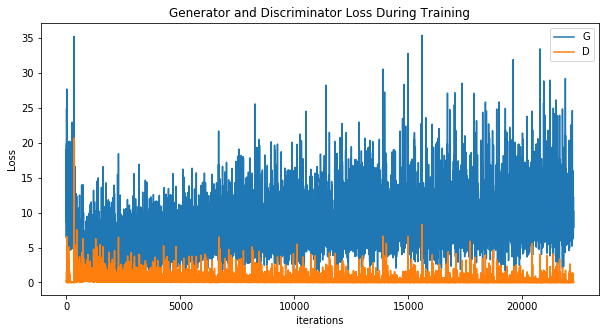

In [20]:
# Plot the Training Losses.

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('./generated_images/type4/discriminator_generator_loss_plot_type4.png')
plt.show()

## Sample Generation from Trained Model

### Sample from each Epochs

In [21]:
with tqdm(params['nepochs']) as pbar:
    for epoch in range(0,params['nepochs'],5):
        path = f'model/type4/model_epoch_{epoch+1}.pth'
        state_dict = torch.load(path,map_location='cpu')

        device = torch.device("cuda")
        params = state_dict['params']

        netG = Generator(params).to(device)
        netG.load_state_dict(state_dict['generator'])

        for i in range(10):
            noise = torch.randn(1, params['nz'], 1, 1, device=device)

            with torch.no_grad():
                generated_img = netG(noise).detach().cpu()

            image_data = np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0))
            plt.imsave(fname=f'./generated_images/type4/pic_generated_{epoch}_{i+1}.png', arr=np.asarray(image_data))
        pbar.update(5)

250it [01:37,  2.55it/s]


### Samples from Final Epoch

In [25]:
path = f'model/type4/model_final.pth'
state_dict = torch.load(path,map_location='cpu')
device = torch.device("cuda")
params = state_dict['params']

netG = Generator(params).to(device)
netG.load_state_dict(state_dict['generator'])

with tqdm(1000) as pbar:
    for i in range(1000):
        noise = torch.randn(1, params['nz'], 1, 1, device=device)
        with torch.no_grad():
            generated_img = netG(noise).detach().cpu()
        
        image_data = np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0))
        plt.imsave(fname=f'./generated_images/4_{i+1}.png', arr=np.asarray(image_data))
        pbar.update(1)

0it [00:00, ?it/s]/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
1000it [02:58,  5.61it/s]


### Learning Transitions across Epochs (Animation)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


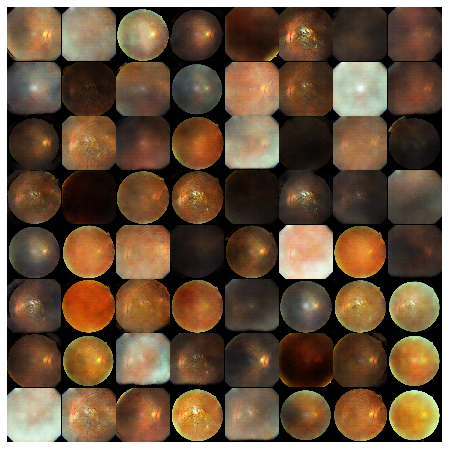

In [23]:
# Animation showing the overall improvements of the generator during the training.

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('./generated_images/type4/fundus_type4.gif', dpi=80, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


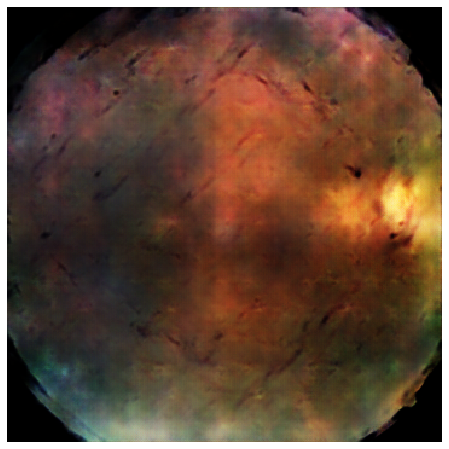

In [24]:
# Animation showing the improvements of the generator for across epoch from generated samples.

img_list = map(plt.imread, sorted(glob.glob('./generated_images/type4/*10.png')))
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('./generated_images/type4/fundus_type4_1.gif', dpi=80, writer='imagemagick')